In [1]:
!pip install qiskit==0.45 mapomatic qiskit_ibm_runtime qiskit_aqua pylatexenc



[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### imports

In [2]:
import numpy as np
import qiskit
from qiskit import *
import mapomatic as mm

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="f7415f2b5a7f9b8231adfea68759c4f287db674fe641f9846b97d367cb6cb5b43be8f5959b7e9ee41f3173d250e77d55cbb6ea0017e9e93a49b560f401cc4ecf")


AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

In [4]:
service = QiskitRuntimeService()

### Getting fake-backends

In [5]:
from qiskit.providers.fake_provider import *

# Create a FakeProvider instance
provider = FakeProvider()

# Get all available backends (their names)
backend_names = [backend.name() for backend in provider.backends()]
fake_backends = [backend for backend in provider.backends()]
print("List of available fake backends:")
for name in backend_names:
    print(name)

List of available fake backends:
fake_almaden
fake_armonk
fake_athens
fake_belem
fake_boeblingen
fake_bogota
fake_brooklyn
fake_burlington
fake_cairo
fake_cambridge
fake_cambridge
fake_casablanca
fake_essex
fake_guadalupe
fake_hanoi
fake_jakarta
fake_johannesburg
fake_kolkata
fake_lagos
fake_lima
fake_london
fake_manila
fake_manhattan
fake_melbourne
fake_montreal
fake_mumbai
fake_nairobi
fake_openpulse_2q
fake_openpulse_3q
fake_ourense
fake_paris
fake_poughkeepsie
fake_qasm_simulator
fake_quito
fake_rochester
fake_rome
fake_rueschlikon
fake_santiago
fake_singapore
fake_sydney
fake_tenerife
fake_tokyo
fake_toronto
fake_valencia
fake_vigo
fake_washington
fake_yorktown


In [6]:
len(backend_names)

47

### getting a list of all fake backends and generating random circuits 

In [7]:
import random

provider = FakeProvider()
fake_backends = provider.backends()

def check_noise_model(backend):
    if backend.options.noise_model:
        print("no noise")
        return backend is not None
    else:
        return False

def generate_circuits(num_circuits, min_qubits=3, max_qubits=7, min_repeats=2, max_repeats=5):
    circuits = []
    for _ in range(num_circuits):
        num_qubits = random.randint(min_qubits, max_qubits)
        num_repeats = random.randint(min_repeats, max_repeats)
        qc = QuantumCircuit(num_qubits)

        # Add random variational layers
        for _ in range(num_repeats):
            # Add random single-qubit rotation gates
            for qubit in range(num_qubits):
                gate_type = random.choice(['rx', 'ry', 'rz'])
                if gate_type == 'rx':
                    qc.rx(random.uniform(0, 2 * np.pi), qubit)
                elif gate_type == 'ry':
                    qc.ry(random.uniform(0, 2 * np.pi), qubit)
                else:
                    qc.rz(random.uniform(0, 2 * np.pi), qubit)

            # Add random two-qubit gates (entangling gates)
            for _ in range(num_qubits // 2):
                gate_type = random.choice(['cx', 'cz', 'swap'])
                qubit_pair = random.sample(range(num_qubits), 2)
                if gate_type == 'cx':
                    qc.cx(qubit_pair[0], qubit_pair[1])
                elif gate_type == 'cz':
                    qc.cz(qubit_pair[0], qubit_pair[1])
                else:
                    qc.swap(qubit_pair[0], qubit_pair[1])

        qc.measure_all()
        circuits.append(qc)
    return circuits

# Generate circuits
circuits = generate_circuits(50)  


C:\Users\Shivalee Shah\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


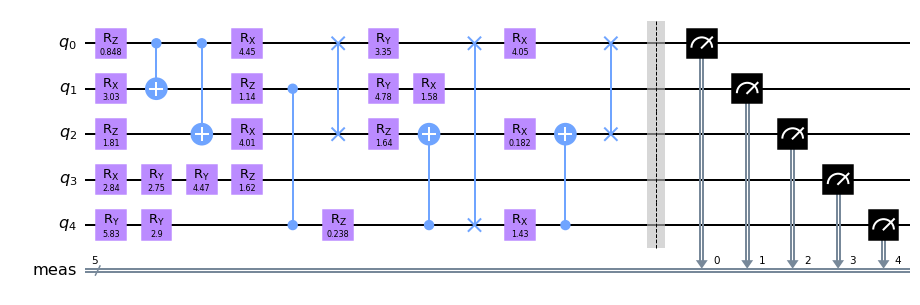

In [8]:
circuits[0].draw("mpl", fold=-1)

### Getting real backends

In [9]:
# Get a list of all available backends
backends = service.backends()
backends

[<IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_sherbrooke')>]

### getting score and running circuit on backend-> fake backend

In [20]:
def get_mapomatic_score(backend, circuit):
    try:
        trans_qc = transpile(circuit, backend, optimization_level=3)
        small_qc = mm.deflate_circuit(trans_qc)
        layouts = mm.matching_layouts(small_qc, backend)
        scores = mm.evaluate_layouts(small_qc, layouts, backend)
        
        return scores[-1][-1]
    
    except Exception as e:
        print("Error occurred:", e)
#         return None  

def run_circuits(circuits, backends):
    data = []
    for backend in backends:
        for circuit in circuits:
            # Calculate mapomatic score
            mapomatic_score = get_mapomatic_score(backend, circuit)
            if mapomatic_score:
                # Simulate the transpiled circuit with noise on the specific backend
                result = backend.run(circuit).result()
                counts = result.get_counts()

                # Calculate some metric, such as expected value
                exp_val = sum(int(key, 2) * val for key, val in counts.items()) / sum(counts.values())

                # Append the data to the list
                data.append({'exp_val': exp_val, 'mapomatic_score': mapomatic_score, 'backend_name': backend.name(), 'num_qubits':circuit.num_qubits
})
    return data




In [ ]:
# Run circuits on fake backends
dataset = run_circuits(circuits, fake_backends)

### Creating datasheet

In [1]:
import pandas as pd

In [24]:
import pandas as pd

df = pd.DataFrame(dataset)
print(df)

        exp_val  mapomatic_score   backend_name  num_qubits
0      8.592773         0.191231    fake_athens           5
1      6.286133         0.376850    fake_athens           4
2      8.914062         0.382650    fake_athens           4
3      3.032227         0.255705    fake_athens           3
4      1.721680         0.168160    fake_athens           3
...         ...              ...            ...         ...
1229   7.953125         0.549304  fake_yorktown           4
1230  12.711914         0.632486  fake_yorktown           5
1231   3.100586         0.481363  fake_yorktown           3
1232  10.245117         0.605373  fake_yorktown           4
1233   3.330078         0.541162  fake_yorktown           3

[1234 rows x 4 columns]


In [25]:
df.to_csv('D:\SIA\ACADS\QML\minor2\dataset_50.csv', index=False)

In [2]:
df = pd.read_csv("D:\SIA\ACADS\QML\minor2\dataset_50.csv")

In [3]:
unique_backend_names = df['backend_name'].nunique()
print("Number of unique backend names:", unique_backend_names)

Number of unique backend names: 29


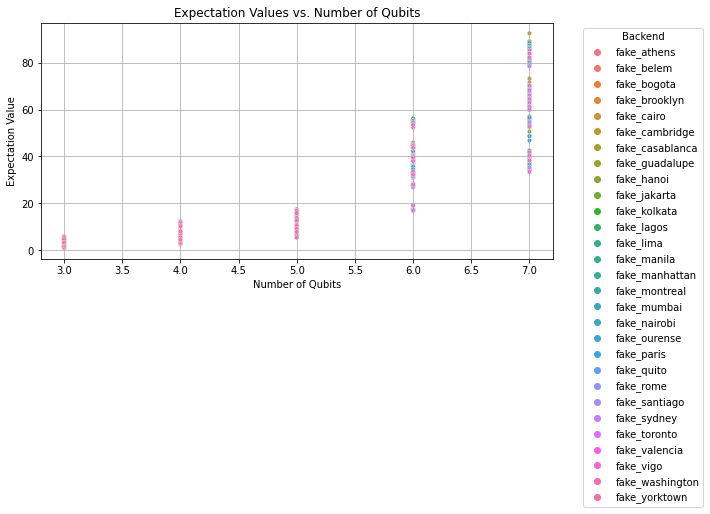

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_qubits', y='exp_val', hue='backend_name', s=20)
plt.title('Expectation Values vs. Number of Qubits')
plt.xlabel('Number of Qubits')
plt.ylabel('Expectation Value')
plt.grid(True)
plt.legend(title='Backend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Regressor Model sia

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


label_encoder = LabelEncoder()
df['backend_code'] = label_encoder.fit_transform(df['backend_name'])

X = df[['mapomatic_score', 'backend_code']]
y = df['exp_val']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


Mean Squared Error: 342.39947355037737
R-squared Score: 0.15315029332769736


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Linear Regression
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred_linear = linear_regressor.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Support Vector Regression (SVR)
svr_regressor = SVR()
svr_regressor.fit(X_train, y_train)
y_pred_svr = svr_regressor.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

# Gradient Boosting Regression
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)
y_pred_gb = gb_regressor.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Print evaluation results for each model
print("Linear Regression:")
print("Mean Squared Error:", mse_linear)
print("R-squared Score:", r2_linear)
print("\nSVR:")
print("Mean Squared Error:", mse_svr)
print("R-squared Score:", r2_svr)
print("\nGradient Boosting Regression:")
print("Mean Squared Error:", mse_gb)
print("R-squared Score:", r2_gb)


Linear Regression:
Mean Squared Error: 341.962976895234
R-squared Score: 0.15422987169427216

SVR:
Mean Squared Error: 476.5648348578457
R-squared Score: -0.17867818669505708

Gradient Boosting Regression:
Mean Squared Error: 274.9704631395249
R-squared Score: 0.31992110373676363


In [6]:
backend_name = 'fake_brooklyn'
mapomatic_score = 0.83

backend_code = label_encoder.transform([backend_name])[0]

data = {'mapomatic_score': [mapomatic_score], 'backend_code': [backend_code]}
prediction_df = pd.DataFrame(data)

predicted_exp_val = regressor.predict(prediction_df)

print(f"Predicted Exp Val for backend_name = {backend_name} and mapomatic_score = {mapomatic_score}: {predicted_exp_val[0]}")


Predicted Exp Val for backend_name = fake_brooklyn and mapomatic_score = 0.83: 67.928740234375


In [7]:
predicted_exp_val_linear = linear_regressor.predict(prediction_df)

predicted_exp_val_svr = svr_regressor.predict(prediction_df)

predicted_exp_val_gb = gb_regressor.predict(prediction_df)

# Print predictions for each regressor
print("Predictions for Linear Regression:")
print(predicted_exp_val_linear[0])
print("\nPredictions for SVR:")
print(predicted_exp_val_svr[0])
print("\nPredictions for Gradient Boosting Regression:")
print(predicted_exp_val_gb[0])

Predictions for Linear Regression:
30.01079769549331

Predictions for SVR:
8.07690306065652

Predictions for Gradient Boosting Regression:
59.92253232796733


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


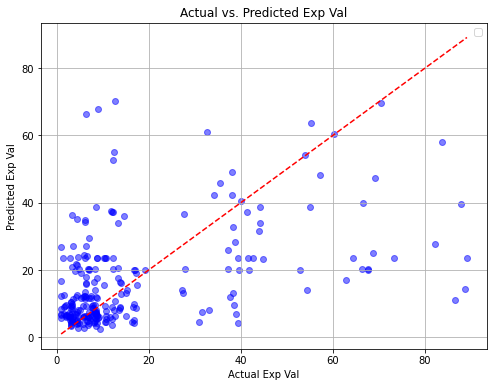

In [8]:
import matplotlib.pyplot as plt

# Plot actual versus predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Exp Val')
plt.ylabel('Predicted Exp Val')
plt.legend()
plt.title('Actual vs. Predicted Exp Val')
plt.grid(True)
plt.show()


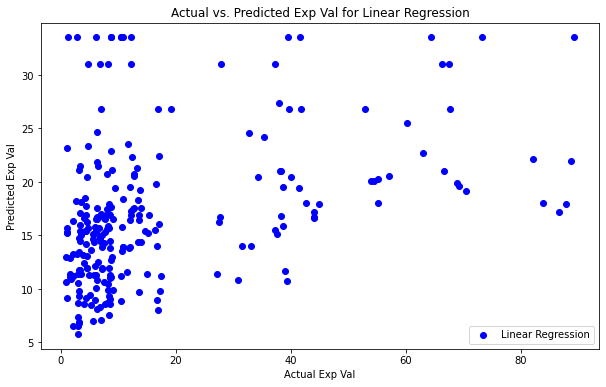

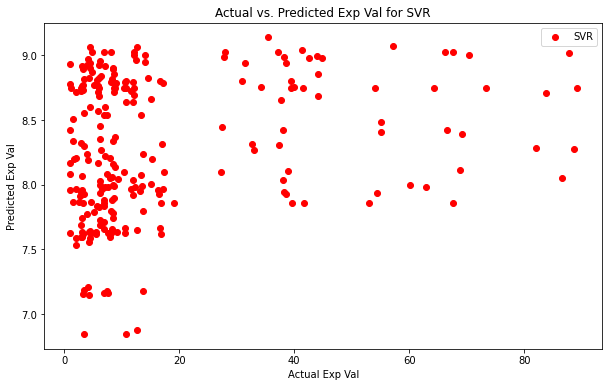

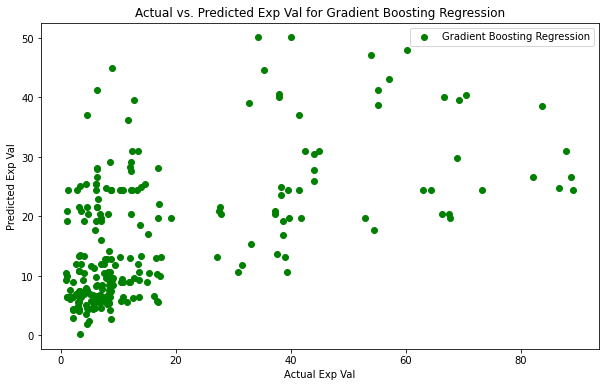

In [9]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, color='blue', label='Linear Regression')
plt.xlabel('Actual Exp Val')
plt.ylabel('Predicted Exp Val')
plt.title('Actual vs. Predicted Exp Val for Linear Regression')
plt.legend()
plt.show()

# Plot actual vs. predicted values for SVR
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, color='red', label='SVR')
plt.xlabel('Actual Exp Val')
plt.ylabel('Predicted Exp Val')
plt.title('Actual vs. Predicted Exp Val for SVR')
plt.legend()
plt.show()

# Plot actual vs. predicted values for Gradient Boosting Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, color='green', label='Gradient Boosting Regression')
plt.xlabel('Actual Exp Val')
plt.ylabel('Predicted Exp Val')
plt.title('Actual vs. Predicted Exp Val for Gradient Boosting Regression')
plt.legend()
plt.show()


### On new data

In [31]:
backend_name = 'fake_brooklyn'
new_data = generate_circuits(1,5,5)
score = get_mapomatic_score(new_data, "")

backend_code = label_encoder.transform([backend_name])[0]

data = {'mapomatic_score': [mapomatic_score], 'backend_code': [backend_code]}
prediction_df = pd.DataFrame(data)

predicted_exp_val = regressor.predict(prediction_df)

predicted_exp_val_linear = linear_regressor.predict(prediction_df)

predicted_exp_val_svr = svr_regressor.predict(prediction_df)

predicted_exp_val_gb = gb_regressor.predict(prediction_df)

# Print predictions for each regressor
print("Predictions for RF Regression:")
print(predicted_exp_val[0])
print("Predictions for Linear Regression:")
print(predicted_exp_val_linear[0])
print("\nPredictions for SVR:")
print(predicted_exp_val_svr[0])
print("\nPredictions for Gradient Boosting Regression:")
print(predicted_exp_val_gb[0])

Error occurred: 'str' object has no attribute 'name'
Predictions for RF Regression:
67.928740234375
Predictions for Linear Regression:
30.01079769549331

Predictions for SVR:
8.07690306065652

Predictions for Gradient Boosting Regression:
59.92253232796733


C:\Users\Shivalee Shah\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


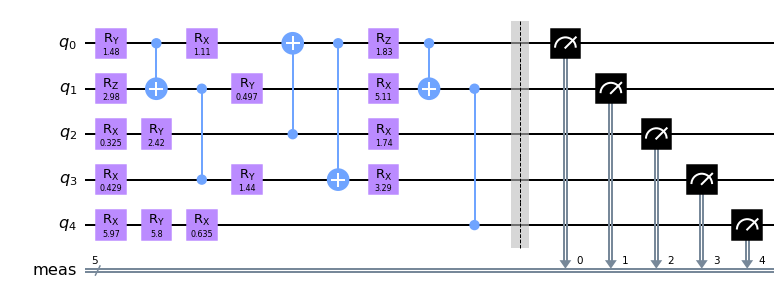

In [32]:
new_data[0].draw("mpl", fold=-1)

actual value

In [27]:
!pip install qiskit-ibmq-provider


[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# provider = IBMQ.load_account()
from qiskit.providers.fake_provider import FakeBrooklyn

backend = FakeBrooklyn()
result = backend.run(new_data).result()
counts = result.get_counts()

# Calculate some metric, such as expected value
exp_val = sum(int(key, 2) * val for key, val in counts.items()) / sum(counts.values())

In [34]:
exp_val

8.8828125

In [30]:
counts

{'00110': 510,
 '00111': 22,
 '10110': 296,
 '10101': 4,
 '00100': 65,
 '00010': 27,
 '10100': 47,
 '10010': 24,
 '10111': 9,
 '01110': 4,
 '11110': 5,
 '00000': 5,
 '10011': 1,
 '01010': 1,
 '00101': 3,
 '11100': 1}

In [23]:
backends

[<IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_sherbrooke')>]

In [17]:
from qiskit import QuantumCircuit, execute, Aer
# Define the backend
backend = Aer.get_backend('qasm_simulator')

In [24]:
backend = backends[1]

In [25]:
simulator_data=[]

In [26]:
for i in circuits:
    result = backend.run(i).result()
    counts = result.get_counts()

    # Calculate some metric, such as expected value
    exp_val = sum(int(key, 2) * val for key, val in counts.items()) / sum(counts.values())
    simulator_data.append({'exp_val': exp_val, 'mapomatic_score': get_mapomatic_score(backend,i), 'num_qubits':i.num_qubits})

Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'graph'
Error occurred: 'NoneType' object has no attribute 'grap

In [29]:
get_mapomatic_score(backend,circuits[0])

Error occurred: 'NoneType' object has no attribute 'graph'


In [31]:
backend.run(circuits[0]).result()

Result(backend_name='qasm_simulator', backend_version='0.13.3', qobj_id='', job_id='Unknown', success=True, results=[ExperimentResult(shots=4000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x10': 8, '0x15': 6, '0x1d': 22, '0x14': 6, '0x13': 20, '0x16': 5, '0x12': 10, '0x1f': 21, '0x19': 65, '0x1b': 40, '0x1e': 20, '0x1c': 14, '0x4': 65, '0x3': 92, '0xe': 280, '0x8': 683, '0x7': 64, '0x11': 11, '0xa': 546, '0xf': 218, '0x6': 84, '0x1a': 24, '0x1': 121, '0xd': 207, '0x0': 172, '0xb': 337, '0x2': 144, '0x9': 409, '0x5': 44, '0xc': 233, '0x17': 9, '0x18': 20}), header=QobjExperimentHeader(creg_sizes=[['meas', 5]], global_phase=0.0, memory_slots=5, metadata={}, n_qubits=5, name='circuit-158', qreg_sizes=[['q', 5]]), status=DONE, seed_simulator=2092490889, metadata={'time_taken': 0.01793019, 'active_input_qubits': [0, 1, 2, 3, 4], 'method': 'statevector', 'remapped_qubits': False, 'num_clbits': 5, 'input_qubit_map': [[4, 4], [3, 3], [2, 2], [0, 0], [1, 1]], 'device': 'CPU

In [28]:
import pandas as pd

df = pd.DataFrame(simulator_data)
df.to_csv('D:\SIA\ACADS\QML\minor2\simulator2.csv', index=False)

In [ ]:
result = backends[5].run(new_data).result()
counts = result.get_counts()

# Calculate some metric, such as expected value
exp_val = sum(int(key, 2) * val for key, val in counts.items()) / sum(counts.values())

In [ ]:
exp_val